In [1]:
import xarray as xa
import numpy as np
import pandas as pd
import geopandas

import datashader as ds
from datashader.transfer_functions import shade, stack, dynspread, set_background

from xrspatial import a_star_search

## Load data

The road network used in this example notebook can be downloaded from:

https://data.austintexas.gov/Locations-and-Maps/Street-Centerline/m5w3-uea6

In [2]:
streets = geopandas.read_file('zip://./data/Street_Centerline.zip')
streets = streets.to_crs({'init': 'epsg:4326'})

xs = []
ys = []
for s in streets.geometry.values:
    try:
        coords = s.coords.xy
        xs += coords[0].tolist()
        ys += coords[1].tolist()
        
        xs.append(np.nan)
        ys.append(np.nan)
    except:
        continue
        
street_df = pd.DataFrame(dict(x=xs, y=ys))

In [3]:
street_df

,x,y
0,-97.683275,30.313282
1,-97.682387,30.313545
2,NaN,NaN
3,-97.839164,30.520563
4,-97.839158,30.520697
...,...,...
426181,-97.876848,30.209246
426182,NaN,NaN
426183,-97.576633,30.491934
426184,-97.575032,30.491721


## Define study area (find range of x and y)

In [4]:
xmin, ymin, xmax, ymax = (streets.geometry.bounds.minx.min(),
                          streets.geometry.bounds.miny.min(),
                          streets.geometry.bounds.maxx.max(),
                          streets.geometry.bounds.maxy.max())
xrange = (xmin, xmax)
yrange = (ymin, ymax)
xrange, yrange

((-98.170507844129, -97.36979731249), (29.995950090365, 30.654731756587))

In [5]:
H, W = 600, 800
cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=xrange, y_range=yrange)

street_agg = cvs.line(street_df, x='x', y='y').astype(int)
street_shaded = dynspread(shade(street_agg, cmap=['salmon']))

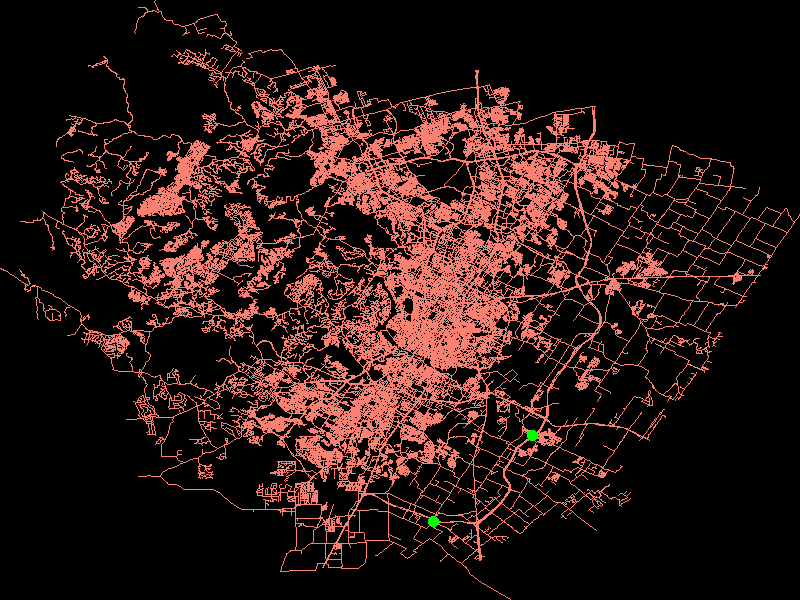

In [6]:
# Pick two locations
start = (-97.73662282, 30.08214069)
goal = (-97.63753489650679, 30.1765660638542)

location_df = pd.DataFrame({'x': [start[0], goal[0]], 'y': [start[1], goal[1]]})
location_agg = cvs.points(location_df, 'x', 'y')
location_shaded = dynspread(shade(location_agg, cmap=['lime']), threshold=1, max_px=5)

set_background(stack(street_shaded, location_shaded), 'black')

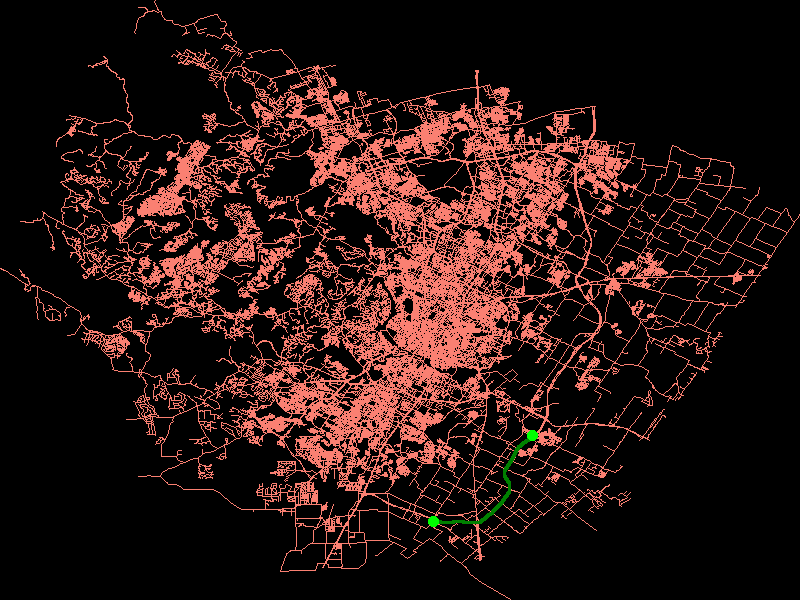

In [7]:
# find the path from start to goal, 
# barriers are uncrossable cells. In this case, they are cells with a value of 0

path_agg = a_star_search(street_agg, start, goal, barriers=[0])

path_shaded = dynspread(shade(path_agg, cmap=['green']))
set_background(stack(street_shaded, path_shaded, location_shaded), 'black')